In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
df = pd.read_csv('../inspection_data/data_50Hz.csv')
df.head()

,success,actual_time,optimal_time,world_idx,timestep,goal_x,goal_y,lidar_0,lidar_1,lidar_2,...,lidar_359,pos_x,pos_y,pose_heading,twist_linear,twist_angular,cmd_vel_linear,cmd_vel_angular,local_goal_x,local_goal_y
0,True,11.53,6.776516,0,0,0.0,10.0,2.953487,2.869737,2.848471,...,3.010891,-0.000056,0.001010,1.547277,0.015216,0.004864,0.09,0.013916,0.997539,0.073423
1,True,11.53,6.776516,0,1,0.0,10.0,2.956702,2.871896,2.849361,...,3.011203,-0.000025,0.002372,1.547351,0.038166,0.012513,0.12,0.018555,1.021175,0.073934
2,True,11.53,6.776516,0,2,0.0,10.0,2.958278,2.869057,2.851222,...,3.013201,0.000020,0.004364,1.547393,0.065010,0.006605,0.15,0.023194,1.019185,0.073891
3,True,11.53,6.776516,0,3,0.0,10.0,2.960670,2.870363,2.851820,...,3.010752,0.000080,0.006967,1.547525,0.093685,0.022431,0.18,0.011172,1.016592,0.073756
4,True,11.53,6.776516,0,4,0.0,10.0,2.962370,2.871268,2.855664,...,3.011739,0.000154,0.010177,1.547590,0.123362,0.008801,0.21,0.013033,1.013386,0.073689


In [2]:
# # remove rows with success = 0
df = df[df['success'] == True]

In [3]:
# torch Dataset
from torch.utils.data import Dataset
import numpy as np

class KULBarnDataset(Dataset):
    def get_normalized_goal(self):
        x = self.data['pos_x']
        y = self.data['pos_y']
        goal_x = self.data['goal_x']
        goal_y = self.data['goal_y']
        theta = self.data['pose_heading']
        self.data['goal_x'] = np.cos(theta) * (goal_x - x) + np.sin(theta) * (goal_y - y)
        self.data['goal_y'] = -np.sin(theta) * (goal_x - x) + np.cos(theta) * (goal_y - y)

    def __init__(self, df, mode="train"):
        super().__init__()

        self.data = df
        self.get_normalized_goal()  
        
        # get all the column values that contain the word lidar
        self.lidar_cols = ["lidar_" + str(i) for i in range(0, 360, 1)]
        # get actions columns
        self.actions_cols = ['cmd_vel_linear', 'cmd_vel_angular']
        # get other columns
        self.non_lidar_cols = ['local_goal_x', 'local_goal_y', 'goal_x', 'goal_y']

        # if mode == "train":
        #     # Manually compute the min and max values for each column
        #     self.min = self.data.min()
        #     self.max = self.data.max()
        #     # Save the mean and std to a JSON file
        #     scaler_params = {
        #         'min': self.min.to_dict(),
        #         'max': self.max.to_dict()
        #     }
        #     with open('scaler_params.json', 'w') as f:
        #         json.dump(scaler_params, f)
        # else:
        #     # Load the mean and std from the JSON file
        #     with open('scaler_params.json', 'r') as f:
        #         scaler_params = json.load(f)
        #     self.min = pd.Series(scaler_params['min'])
        #     self.max = pd.Series(scaler_params['max'])
        
        # dont normalizer local_x and local_y
        # self.normalized_data = (self.data - self.min) / (self.max - self.min)
        self.normalized_data = self.data
         
        self.lidar_data = self.normalized_data[self.lidar_cols].values
        self.non_lidar_data = self.normalized_data[self.non_lidar_cols].values
        self.actions_data = self.normalized_data[self.actions_cols].values

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        lidar = self.lidar_data[idx]
        non_lidar = self.non_lidar_data[idx]
        actions = self.actions_data[idx]
        return lidar, non_lidar, actions

In [4]:
# take random 90% of the world ids for training
ids = df['world_idx'].unique()

test_ids = list(range(0, 300, 5))

non_test_ids = np.setdiff1d(ids, test_ids)

train_ids = np.random.choice(non_test_ids, int(0.8 * len(non_test_ids)), replace=False)
train_df = df[df['world_idx'].isin(train_ids)]
train_dataset = KULBarnDataset(train_df, mode="train")

# take the remaining of the world ids for validation
val_ids = np.setdiff1d(non_test_ids, train_ids)
val_df = df[df['world_idx'].isin(val_ids)]
val_dataset = KULBarnDataset(val_df, mode="val")

In [5]:
print(len(train_ids), len(val_ids))

192 48


In [6]:
print("Train Dataset Length:", len(train_dataset))
print("Val Dataset Length:", len(val_dataset))

Train Dataset Length: 356623
Val Dataset Length: 86379


In [7]:
# dataloader
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
# test dataloader
lidar, non_lidar, actions = next(iter(train_loader))
print(f"Non lidar shape: {non_lidar.shape}")
print(f"Lidar shape: {lidar.shape}")
# print size dataloader
print(f"Train loader size: {len(train_loader)}")
print(f"Val loader size: {len(val_loader)}")
print(lidar, non_lidar, actions)

Non lidar shape: torch.Size([64, 4])
Lidar shape: torch.Size([64, 360])
Train loader size: 5573
Val loader size: 1350
tensor([[1.2042, 1.2010, 1.2006,  ..., 0.7230, 0.7289, 0.7393],
        [5.0000, 5.0000, 5.0000,  ..., 1.8720, 1.8806, 1.8984],
        [4.3470, 4.5073, 4.7787,  ..., 0.6869, 0.7010, 0.8091],
        ...,
        [5.0000, 5.0000, 5.0000,  ..., 5.0000, 5.0000, 5.0000],
        [1.0508, 1.0547, 1.0599,  ..., 5.0000, 5.0000, 5.0000],
        [0.6421, 0.6455, 0.6493,  ..., 0.9102, 0.9169, 0.9384]],
       dtype=torch.float64) tensor([[ 1.0088e+00, -3.5703e-02,  5.9112e+00, -5.7129e-01],
        [ 9.8328e-01,  2.6551e-01,  3.7076e+00,  6.4741e+00],
        [ 9.6028e-01,  2.8164e-01,  3.5545e+00,  4.2327e+00],
        [ 9.8061e-01,  2.1264e-01,  5.1315e+00, -5.5955e+00],
        [ 1.0209e+00,  3.8610e-02,  5.1080e+00, -4.9602e-01],
        [ 1.0104e+00,  2.7528e-02,  6.7788e+00, -2.6475e-01],
        [ 1.0004e+00, -5.7744e-02,  1.4542e+00, -1.6251e-01],
        [ 1.0119e+00, 

In [8]:
lidar

tensor([[1.2042, 1.2010, 1.2006,  ..., 0.7230, 0.7289, 0.7393],
        [5.0000, 5.0000, 5.0000,  ..., 1.8720, 1.8806, 1.8984],
        [4.3470, 4.5073, 4.7787,  ..., 0.6869, 0.7010, 0.8091],
        ...,
        [5.0000, 5.0000, 5.0000,  ..., 5.0000, 5.0000, 5.0000],
        [1.0508, 1.0547, 1.0599,  ..., 5.0000, 5.0000, 5.0000],
        [0.6421, 0.6455, 0.6493,  ..., 0.9102, 0.9169, 0.9384]],
       dtype=torch.float64)

In [9]:
non_lidar

tensor([[ 1.0088e+00, -3.5703e-02,  5.9112e+00, -5.7129e-01],
        [ 9.8328e-01,  2.6551e-01,  3.7076e+00,  6.4741e+00],
        [ 9.6028e-01,  2.8164e-01,  3.5545e+00,  4.2327e+00],
        [ 9.8061e-01,  2.1264e-01,  5.1315e+00, -5.5955e+00],
        [ 1.0209e+00,  3.8610e-02,  5.1080e+00, -4.9602e-01],
        [ 1.0104e+00,  2.7528e-02,  6.7788e+00, -2.6475e-01],
        [ 1.0004e+00, -5.7744e-02,  1.4542e+00, -1.6251e-01],
        [ 1.0119e+00, -2.5100e-02,  3.0506e+00, -2.9924e-01],
        [ 1.0069e+00, -1.2296e-01,  3.9403e+00, -1.7460e+00],
        [ 1.0090e+00, -3.6122e-02,  7.7484e+00,  1.3032e-01],
        [ 1.0080e+00, -1.3317e-02,  7.5919e+00, -4.8836e-01],
        [ 1.0002e+00, -1.4965e-02,  8.9064e+00, -5.4051e-01],
        [ 9.9914e-01,  5.2376e-02,  3.4837e+00,  4.0771e-01],
        [ 1.0133e+00,  5.2077e-02,  6.4892e+00, -3.1805e+00],
        [ 9.9290e-01, -1.7476e-01,  9.1501e+00, -2.2815e+00],
        [ 1.0221e+00, -3.7916e-02,  6.0536e+00,  2.6381e+00],
        

In [10]:
actions

tensor([[ 0.8000, -0.0439],
        [ 0.8000,  0.0693],
        [ 0.8000,  0.1975],
        [ 0.8000,  0.5774],
        [ 0.8000,  0.0427],
        [ 0.8000,  0.0486],
        [ 0.8000, -0.1114],
        [ 0.8000, -0.0254],
        [ 0.8000, -0.1851],
        [ 0.8000, -0.0370],
        [ 0.8000, -0.0192],
        [ 0.8000, -0.0275],
        [ 0.8000,  0.0937],
        [ 0.8000,  0.0948],
        [ 0.8000, -0.2924],
        [ 0.8000, -0.0681],
        [ 0.8000, -0.0447],
        [ 0.8000, -0.0392],
        [ 0.8000, -0.4009],
        [ 0.8000,  0.0790],
        [ 0.8000, -0.0270],
        [ 0.8000,  0.7568],
        [ 0.8000,  1.2275],
        [ 0.5700, -0.0952],
        [ 0.8000, -0.4648],
        [ 0.8000, -0.0829],
        [ 0.8000, -0.0935],
        [ 0.8000,  1.0782],
        [ 0.8000, -0.5708],
        [ 0.8000, -0.1664],
        [ 0.8000, -0.1036],
        [ 0.8000, -0.0722],
        [ 0.8000, -0.0649],
        [ 0.8000, -0.0859],
        [ 0.8000, -0.1014],
        [ 0.8000, -0

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class CNNModel(nn.Module):
    def __init__(self, num_lidar_features, num_non_lidar_features, num_actions, nframes=1):
        super(CNNModel, self).__init__()
        self.act_fea_cv1 = nn.Conv1d(
            in_channels=nframes, out_channels=32, kernel_size=5, stride=2, padding=6, padding_mode='circular'
        )
        self.act_fea_cv2 = nn.Conv1d(
            in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=1
        )

        with torch.no_grad():
            sample_input = torch.randn(1, nframes, num_lidar_features)
            sample_output = self.act_fea_cv1(sample_input)
            sample_output = self.act_fea_cv2(sample_output)
            conv_output_size = sample_output.view(1, -1).shape[1]

        # Calculate the output size of the CNN
        self.fc1 = nn.Linear(conv_output_size, 64)
        self.fc2 = nn.Linear(64 + num_non_lidar_features * nframes, 64)
        self.fc3 = nn.Linear(64, num_actions)

        torch.nn.init.xavier_uniform_(self.fc1.weight)
        torch.nn.init.xavier_uniform_(self.fc2.weight)

    def forward(self, lidar, non_lidar):
        feat = F.relu(self.act_fea_cv1(lidar))
        feat = F.relu(self.act_fea_cv2(feat))
        feat = feat.view(feat.shape[0], -1)
        feat = F.relu(self.fc1(feat))
        # feat = torch.cat((feat, non_lidar.view(non_lidar.shape[0], -1)), dim=-1)
        feat = torch.cat((feat, non_lidar.flatten(start_dim=1)), dim=-1)
        feat = F.relu(self.fc2(feat))
        feat = self.fc3(feat)
        return feat

In [12]:
# make a CustomLoss prioritizing the angular velocity
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, pred, target):
        # increase the loss of the second element of the prediction
        # this is the angular velocity
        loss = (pred - target) ** 2
        loss[:, 1] *= 2
        return loss.mean()

In [13]:
# Initialize the model
num_lidar_features = len(train_dataset.lidar_cols)
num_non_lidar_features = len(train_dataset.non_lidar_cols)
num_actions = len(train_dataset.actions_cols)
model = CNNModel(num_lidar_features, num_non_lidar_features, num_actions)

# Define the loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# Move the model and loss function to the GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
loss_fn = loss_fn.to(device)
print(device)

cuda


In [14]:
from tqdm import tqdm

def train_model(model, train_loader, loss_fn, optimizer):
    model.train()

    losses = []
    for lidar, non_lidar, actions in tqdm(train_loader):
        # Move the data to the device that is used
        lidar = lidar.to(device).unsqueeze(1)
        non_lidar = non_lidar.to(device).unsqueeze(1)
        actions = actions.to(device)

        # Forward pass
        actions_pred = model(lidar.float(), non_lidar.float())
        loss = loss_fn(actions_pred, actions.float())

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Save the loss
        losses.append(loss.item())

    # return the average loss for this epoch
    return sum(losses)/len(losses)

In [15]:
def test_model(model, test_loader, loss_fn):
    model.eval()

    losses = []
    for lidar, non_lidar, actions in tqdm(test_loader):
        # Move the data to the device that is used
        lidar = lidar.to(device).unsqueeze(1)
        non_lidar = non_lidar.to(device).unsqueeze(1)
        actions = actions.to(device)

        # Forward pass
        actions_pred = model(lidar.float(), non_lidar.float())
        loss = loss_fn(actions_pred, actions.float())

        # Save the loss
        losses.append(loss.item())

    # return the average loss for this epoch
    return sum(losses)/len(losses)

In [16]:
import sys
NUM_EPOCHS = 50

random_val_loss = test_model(model, val_loader, loss_fn)
print("Random val loss:", random_val_loss)
sys.stdout.flush()

cnn_train_losses = []
cnn_val_losses = []
best_val_loss = float('inf')
patience = 3
no_improve_epochs = 0

for epoch in range(NUM_EPOCHS):
    train_loss = train_model(model, train_loader, loss_fn, optimizer)
    val_loss = test_model(model, val_loader, loss_fn)
    cnn_train_losses.append(train_loss)
    cnn_val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Train Loss: {train_loss} | Val Loss: {val_loss}")
    sys.stdout.flush()

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improve_epochs = 0
    else:
        no_improve_epochs += 1
        if no_improve_epochs >= patience:
            print("Early stopping due to no improvement after {} epochs.".format(patience))
            break

100%|██████████| 1350/1350 [00:07<00:00, 192.54it/s]

Random val loss: 0.5138106651769744



100%|██████████| 1350/1350 [00:04<00:00, 334.13it/s]

Epoch 1/50 | Train Loss: 0.0387804846445768 | Val Loss: 0.017080062226493654



100%|██████████| 1350/1350 [00:01<00:00, 762.89it/s]

Epoch 2/50 | Train Loss: 0.02285634203275531 | Val Loss: 0.013792185841798697



100%|██████████| 1350/1350 [00:09<00:00, 135.51it/s]

Epoch 3/50 | Train Loss: 0.018761545282618287 | Val Loss: 0.011999342738892194



100%|██████████| 1350/1350 [00:01<00:00, 731.17it/s]

Epoch 4/50 | Train Loss: 0.016143891194418523 | Val Loss: 0.010430850670263343



100%|██████████| 1350/1350 [00:03<00:00, 358.43it/s]

Epoch 5/50 | Train Loss: 0.014307433413308219 | Val Loss: 0.009382476500026382



100%|██████████| 1350/1350 [00:01<00:00, 771.71it/s]

Epoch 6/50 | Train Loss: 0.013011338427568764 | Val Loss: 0.008667857120750274



100%|██████████| 1350/1350 [00:01<00:00, 702.42it/s]

Epoch 7/50 | Train Loss: 0.012065480703682846 | Val Loss: 0.0080758580337257



100%|██████████| 1350/1350 [00:02<00:00, 651.45it/s]

Epoch 8/50 | Train Loss: 0.011381997310933478 | Val Loss: 0.007871439822184686



100%|██████████| 1350/1350 [00:01<00:00, 861.70it/s]

Epoch 9/50 | Train Loss: 0.010872564355874689 | Val Loss: 0.0075036386478017515



100%|██████████| 1350/1350 [00:01<00:00, 772.18it/s]

Epoch 10/50 | Train Loss: 0.010460491435290306 | Val Loss: 0.007437619019423167



100%|██████████| 1350/1350 [00:01<00:00, 740.27it/s]

Epoch 11/50 | Train Loss: 0.010123426232540606 | Val Loss: 0.0072810020091775285



100%|██████████| 1350/1350 [00:01<00:00, 697.16it/s]

Epoch 12/50 | Train Loss: 0.009843215866413929 | Val Loss: 0.007161839282818147



100%|██████████| 1350/1350 [00:02<00:00, 560.46it/s]

Epoch 13/50 | Train Loss: 0.009602690890162184 | Val Loss: 0.006881576156045884



100%|██████████| 1350/1350 [00:01<00:00, 744.55it/s]

Epoch 14/50 | Train Loss: 0.009379438248448937 | Val Loss: 0.006859536994220603



100%|██████████| 1350/1350 [00:02<00:00, 638.44it/s]

Epoch 15/50 | Train Loss: 0.009184386132817421 | Val Loss: 0.006882030374685268



100%|██████████| 1350/1350 [00:02<00:00, 606.88it/s]

Epoch 16/50 | Train Loss: 0.008993755918815943 | Val Loss: 0.006812933875976509



100%|██████████| 1350/1350 [00:02<00:00, 642.34it/s]

Epoch 17/50 | Train Loss: 0.008832201669395382 | Val Loss: 0.00683390654817534



100%|██████████| 1350/1350 [00:01<00:00, 786.16it/s]

Epoch 18/50 | Train Loss: 0.008685829098362803 | Val Loss: 0.006917421759892561



100%|██████████| 1350/1350 [00:01<00:00, 789.84it/s]

Epoch 19/50 | Train Loss: 0.008547832600878665 | Val Loss: 0.006644121091540675



100%|██████████| 1350/1350 [00:01<00:00, 735.74it/s]

Epoch 20/50 | Train Loss: 0.008424441207630355 | Val Loss: 0.006666546161201646



100%|██████████| 1350/1350 [00:01<00:00, 771.70it/s]

Epoch 21/50 | Train Loss: 0.008286525341532987 | Val Loss: 0.006782489792126903



100%|██████████| 1350/1350 [00:01<00:00, 754.31it/s]

Epoch 22/50 | Train Loss: 0.008181004540618925 | Val Loss: 0.006631491503519808



100%|██████████| 1350/1350 [00:01<00:00, 791.08it/s]

Epoch 23/50 | Train Loss: 0.008074728711204486 | Val Loss: 0.00664151814963757



100%|██████████| 1350/1350 [00:01<00:00, 776.62it/s]

Epoch 24/50 | Train Loss: 0.00796195498232369 | Val Loss: 0.006683722158518827



100%|██████████| 1350/1350 [00:01<00:00, 761.95it/s]

Epoch 25/50 | Train Loss: 0.00786638151071852 | Val Loss: 0.006703142836017327


Early stopping due to no improvement after 3 epochs.


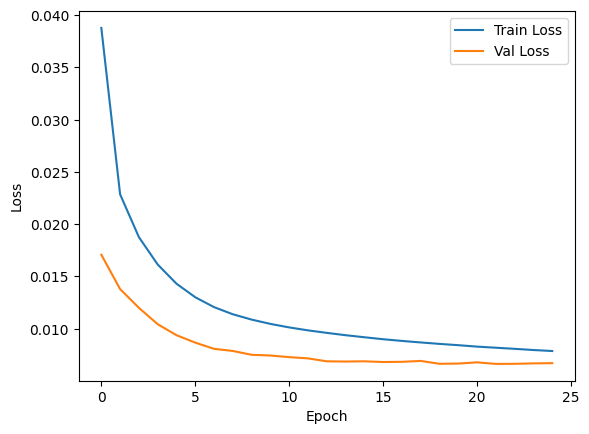

In [17]:
# plot the loss
import matplotlib.pyplot as plt

plt.plot(cnn_train_losses, label='Train Loss')
plt.plot(cnn_val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show();

In [18]:
# save the model
torch.save(model.state_dict(), 'models/cnn_model.pth')

In [19]:
def test_model(model, test_loader, loss_fn):
    model.eval()

    losses = []
    for lidar, non_lidar, actions in tqdm(test_loader):
        # Move the data to the device that is used
        lidar = lidar.to(device).unsqueeze(1)
        non_lidar = non_lidar.to(device).unsqueeze(1)
        actions = actions.to(device)

        # Forward pass
        actions_pred = model(lidar.float(), non_lidar.float())
        loss = loss_fn(actions_pred, actions.float())

        if loss.item() > 0.1:
            print("---------------------------")
            print("Loss:", loss.item())
            print("Predicted:", actions_pred)
            print("Actual:", actions)
            print("Non lidar:", non_lidar)
            continue

        # Save the loss
        losses.append(loss.item())

    # return the average loss for this epoch
    return sum(losses)/len(losses)

In [20]:
# load file and check MSELoss
model = CNNModel(num_lidar_features, num_non_lidar_features, num_actions)
model.load_state_dict(torch.load('models/cnn_model.pth', map_location=torch.device('cpu')))
model.eval()
device = 'cpu'

# take world idx 0 as example
dataset = KULBarnDataset(df[df['world_idx'] == 0], "val")
loader = DataLoader(dataset, batch_size=1, shuffle=False)

final_val_loss = test_model(model, loader, loss_fn)
print("Final val loss:", final_val_loss)

 24%|██▎       | 422/1789 [00:00<00:00, 2303.58it/s]

---------------------------
Loss: 0.2144078016281128
Predicted: tensor([[0.7366, 0.1176]], grad_fn=<AddmmBackward0>)
Actual: tensor([[0.0900, 0.0139]], dtype=torch.float64)
Non lidar: tensor([[[0.9975, 0.0734, 9.9962, 0.2351]]], dtype=torch.float64)
---------------------------
Loss: 0.199073925614357
Predicted: tensor([[0.7432, 0.1173]], grad_fn=<AddmmBackward0>)
Actual: tensor([[0.1200, 0.0186]], dtype=torch.float64)
Non lidar: tensor([[[1.0212, 0.0739, 9.9949, 0.2343]]], dtype=torch.float64)
---------------------------
Loss: 0.1799062341451645
Predicted: tensor([[0.7424, 0.1174]], grad_fn=<AddmmBackward0>)
Actual: tensor([[0.1500, 0.0232]], dtype=torch.float64)
Non lidar: tensor([[[1.0192, 0.0739, 9.9929, 0.2339]]], dtype=torch.float64)
---------------------------
Loss: 0.16288241744041443
Predicted: tensor([[0.7412, 0.1153]], grad_fn=<AddmmBackward0>)
Actual: tensor([[0.1800, 0.0112]], dtype=torch.float64)
Non lidar: tensor([[[1.0166, 0.0738, 9.9903, 0.2326]]], dtype=torch.float64)


100%|██████████| 1789/1789 [00:00<00:00, 2780.41it/s]

---------------------------
Loss: 0.18309138715267181
Predicted: tensor([[0.7569, 0.2230]], grad_fn=<AddmmBackward0>)
Actual: tensor([[0.1800, 0.0403]], dtype=torch.float64)
Non lidar: tensor([[[1.0119, 0.1120, 9.9331, 1.0930]]], dtype=torch.float64)
---------------------------
Loss: 0.16416116058826447
Predicted: tensor([[0.7556, 0.2220]], grad_fn=<AddmmBackward0>)
Actual: tensor([[0.2100, 0.0470]], dtype=torch.float64)
Non lidar: tensor([[[1.0088, 0.1116, 9.9304, 1.0889]]], dtype=torch.float64)
---------------------------
Loss: 0.14629240334033966
Predicted: tensor([[0.7545, 0.2207]], grad_fn=<AddmmBackward0>)
Actual: tensor([[0.2400, 0.0537]], dtype=torch.float64)
Non lidar: tensor([[[1.0051, 0.1109, 9.9274, 1.0827]]], dtype=torch.float64)
---------------------------
Loss: 0.12980231642723083
Predicted: tensor([[0.7552, 0.2161]], grad_fn=<AddmmBackward0>)
Actual: tensor([[0.2700, 0.0605]], dtype=torch.float64)
Non lidar: tensor([[[1.0009, 0.1103, 9.9237, 1.0763]]], dtype=torch.float

In [21]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F


class MultiHeadAttention(nn.Module):
    def __init__(
            self,
            input_dim,
            num_heads,
            dropout=0.0,
            bias=False,
            encoder_decoder_attention=False,
            causal=False
    ):
        super().__init__()
        self.input_dim = input_dim
        self.num_heads = num_heads
        self.dropout = dropout
        self.head_dim = input_dim // num_heads
        self.encoder_decoder_attention = encoder_decoder_attention
        self.causal = causal
        self.k_proj = nn.Linear(input_dim, input_dim, bias=bias)
        self.v_proj = nn.Linear(input_dim, input_dim, bias=bias)
        self.q_proj = nn.Linear(input_dim, input_dim, bias=bias)
        self.out_proj = nn.Linear(input_dim, input_dim, bias=bias)

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_heads, self.head_dim,)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def multi_head_scaled_dot_product(self,
                                      query: torch.Tensor,
                                      key: torch.Tensor,
                                      value: torch.Tensor,
                                      attention_mask: torch.BoolTensor):
        attn_weights = torch.matmul(query, key.transpose(-1, -2) / math.sqrt(self.input_dim))
        if attention_mask is not None:
            if self.causal:
                attn_weights = attn_weights.masked_fill(attention_mask.unsqueeze(0).unsqueeze(1), float("-inf"))
            else:
                attn_weights = attn_weights.masked_fill(attention_mask.unsqueeze(1).unsqueeze(2), float("-inf"))
        attn_weights = F.softmax(attn_weights, dim=-1)
        attn_probs = F.dropout(attn_weights, p=self.dropout, training=self.training)
        attn_output = torch.matmul(attn_probs, value)
        attn_output = attn_output.permute(0, 2, 1, 3).contiguous()
        concat_attn_output_shape = attn_output.size()[:-2] + (self.input_dim,)
        attn_output = attn_output.view(*concat_attn_output_shape)
        attn_output = self.out_proj(attn_output)
        return attn_output, attn_weights

    def forward(
            self,
            query: torch.Tensor,
            key: torch.Tensor,
            attention_mask: torch.BoolTensor):
        q = self.q_proj(query)
        if self.encoder_decoder_attention:
            k = self.k_proj(key)
            v = self.v_proj(key)
        else:
            k = self.k_proj(query)
            v = self.v_proj(query)
        q = self.transpose_for_scores(q)
        k = self.transpose_for_scores(k)
        v = self.transpose_for_scores(v)

        attn_output, attn_weights = self.multi_head_scaled_dot_product(q, k, v, attention_mask)
        return attn_output, attn_weights


class PositionWiseFeedForward(nn.Module):

    def __init__(self, input_dim: int, d_ff: int, dropout: float = 0.1):
        super(PositionWiseFeedForward, self).__init__()

        self.activation = nn.ReLU()
        self.w_1 = nn.Linear(input_dim, d_ff)
        self.w_2 = nn.Linear(d_ff, input_dim)
        self.dropout = dropout

    def forward(self, x):
        residual = x
        x = self.activation(self.w_1(x))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.w_2(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        return x + residual


class EmbeddingLidar(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.len_lidar = config.lidar_dim
        self.num_patch = config.num_patch
        self.dim_patch = self.len_lidar // self.num_patch
        self.model_dim = config.model_dim
        self.dropout = config.dropout
        self.pos_embed = nn.Parameter(torch.randn(self.num_patch, self.model_dim))

        self.linear = nn.Linear(self.dim_patch, self.model_dim)

    def forward(self, inputs):
        x = inputs.view([-1, self.num_patch, self.dim_patch])
        x = self.linear(x)
        x = x + self.pos_embed
        x = F.dropout(x, p=self.dropout, training=self.training)
        return x


class EncoderLayer(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.input_dim = config.input_dim
        self.ffn_dim = config.ffn_dim
        self.self_attn = MultiHeadAttention(
            input_dim=self.input_dim,
            num_heads=config.attention_heads,
            dropout=config.attention_dropout)
        self.self_attn_layer_norm = nn.LayerNorm(self.input_dim)
        self.dropout = config.dropout
        self.activation_fn = nn.ReLU()
        self.PositionWiseFeedForward = PositionWiseFeedForward(self.input_dim, self.ffn_dim, config.dropout)
        self.final_layer_norm = nn.LayerNorm(self.input_dim)

    def forward(self, x, encoder_padding_mask):
        residual = x
        x, attn_weights = self.self_attn(query=x, key=x, attention_mask=encoder_padding_mask)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = residual + x
        x = self.self_attn_layer_norm(x)
        x = self.PositionWiseFeedForward(x)
        x = self.final_layer_norm(x)
        return x, attn_weights


class Encoder(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.dropout = config.dropout

        self.embedding = EmbeddingLidar(config)

        self.layers = nn.ModuleList([EncoderLayer(config) for _ in range(config.encoder_layers)])

    def forward(self, inputs, attention_mask=None):
        x = self.embedding(inputs)
        self_attn_scores = []
        for encoder_layer in self.layers:
            x, attn = encoder_layer(x, attention_mask)
            self_attn_scores.append(attn.detach())

        return x, self_attn_scores


class DecoderLayer(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.input_dim = config.input_dim
        self.ffn_dim = config.ffn_dim
        self.dropout = config.dropout
        self.self_attn_layer_norm = nn.LayerNorm(self.input_dim)
        self.encoder_attn = MultiHeadAttention(
            input_dim=self.input_dim,
            num_heads=config.attention_heads,
            dropout=config.attention_dropout,
            encoder_decoder_attention=True,
        )
        self.encoder_attn_layer_norm = nn.LayerNorm(self.input_dim)
        self.PositionWiseFeedForward = PositionWiseFeedForward(self.input_dim, self.ffn_dim, config.dropout)
        self.final_layer_norm = nn.LayerNorm(self.input_dim)

    def forward(
            self,
            x,
            encoder_hidden_states,
            encoder_attention_mask=None,
    ):
        residual = x
        x, cross_attn_weights = self.encoder_attn(
            query=x,
            key=encoder_hidden_states,
            attention_mask=encoder_attention_mask,
        )
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = residual + x
        x = self.encoder_attn_layer_norm(x)
        x = self.PositionWiseFeedForward(x)
        x = self.final_layer_norm(x)

        return (
            x,
            cross_attn_weights,
        )
    

class Decoder(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.dropout = config.dropout
        self.model_dim = config.model_dim
        self.linear = nn.Linear(1, self.model_dim)
        self.layers = nn.ModuleList([DecoderLayer(config) for _ in range(config.decoder_layers)])

    def forward(
            self,
            inputs,
            encoder_hidden_states,
    ):
        x = inputs
        x = self.linear(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        cross_attention_scores = []
        for idx, decoder_layer in enumerate(self.layers):
            x, layer_cross_attn = decoder_layer(
                x,
                encoder_hidden_states,
            )
            cross_attention_scores.append(layer_cross_attn.detach())
        return x, cross_attention_scores


class Transformer(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.non_lidar_dim = config.non_lidar_dim
        self.model_dim = config.model_dim
        self.encoder = Encoder(config)
        self.decoder = Decoder(config)

        self.prediction_head = nn.Linear(self.model_dim * self.non_lidar_dim, 2)

        self.init_weights()

    def init_weights(self):
        for name, param in self.named_parameters():
            if param.requires_grad:
                if 'weight' in name:
                    nn.init.normal_(param.data, mean=0, std=0.01)
                else:
                    nn.init.constant_(param.data, 0)

    def forward(self, src, trg):
        encoder_output, encoder_attention_scores = self.encoder(
            inputs=src
        )
        decoder_output, decoder_attention_scores = self.decoder(
            trg,
            encoder_output
        )
        decoder_output = decoder_output.view(-1, self.model_dim * self.non_lidar_dim)
        decoder_output = self.prediction_head(decoder_output)
        
        return decoder_output, encoder_attention_scores, decoder_attention_scores

In [22]:
def train_model(model, train_loader, loss_fn, optimizer):
    model.train()

    losses = []
    for lidar, non_lidar, actions in tqdm(train_loader):
        lidar = lidar.to(device).unsqueeze(-1)
        non_lidar = non_lidar.to(device).unsqueeze(-1)
        actions = actions.to(device)

        actions_pred, _, _ = model(lidar.float(), non_lidar.float())
        loss = loss_fn(actions_pred, actions.float())

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Save the loss
        losses.append(loss.item())

    # return the average loss for this epoch
    return sum(losses)/len(losses)

In [23]:
def test_model(model, test_loader, loss_fn):
    model.eval()

    losses = []
    for lidar, non_lidar, actions in tqdm(test_loader):
        lidar = lidar.to(device).unsqueeze(-1)
        non_lidar = non_lidar.to(device).unsqueeze(-1)
        actions = actions.to(device)

        actions_pred, _, _ = model(lidar.float(), non_lidar.float())

        loss = loss_fn(actions_pred, actions.float())

        losses.append(loss.item())

    # return the average loss for this epoch
    return sum(losses)/len(losses)

In [24]:
import easydict

# Initialize the model
num_lidar_features = len(train_dataset.lidar_cols)
num_non_lidar_features = len(train_dataset.non_lidar_cols)
num_actions = len(train_dataset.actions_cols)

config_dict = easydict.EasyDict({
    "input_dim": 32,
    "num_patch": 36,
    "model_dim": 32,
    "ffn_dim": 256,
    "attention_heads": 4,
    "attention_dropout": 0.0,
    "dropout": 0.5,
    "encoder_layers": 2,
    "decoder_layers": 2,
    "lidar_dim": 360,
    "non_lidar_dim": 4,
    "device": "cpu",
})

model = Transformer(config_dict)

# Define the loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# Move the model and loss function to the GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
loss_fn = loss_fn.to(device)
print(device)

cuda


In [25]:
import sys
NUM_EPOCHS = 50

random_val_loss = test_model(model, val_loader, loss_fn)
print("Random val loss:", random_val_loss)

transformer_train_losses = []
transformer_val_losses = []
best_val_loss = float('inf')
patience = 3
no_improve_epochs = 0
save_every = 5

for epoch in range(1, NUM_EPOCHS+1):
    train_loss = train_model(model, train_loader, loss_fn, optimizer)
    val_loss = test_model(model, val_loader, loss_fn)
    transformer_train_losses.append(train_loss)
    transformer_val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Train Loss: {train_loss} | Val Loss: {val_loss}")
    sys.stdout.flush()

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improve_epochs = 0
    else:
        no_improve_epochs += 1
        if no_improve_epochs >= patience:
            print("Early stopping due to no improvement after {} epochs.".format(patience))
            break

100%|██████████| 1350/1350 [00:04<00:00, 270.63it/s]


Random val loss: 0.3473640583841889


100%|██████████| 1350/1350 [00:04<00:00, 284.10it/s]

Epoch 2/50 | Train Loss: 0.14920923888744148 | Val Loss: 0.031456381092624115



100%|██████████| 1350/1350 [00:04<00:00, 281.60it/s]

Epoch 3/50 | Train Loss: 0.037344926524698126 | Val Loss: 0.019525746384633412



100%|██████████| 1350/1350 [00:04<00:00, 300.22it/s]

Epoch 4/50 | Train Loss: 0.02536240219196718 | Val Loss: 0.013565705831300606



100%|██████████| 1350/1350 [00:04<00:00, 310.02it/s]

Epoch 5/50 | Train Loss: 0.018067979336278062 | Val Loss: 0.01118924979655141



100%|██████████| 1350/1350 [00:04<00:00, 328.65it/s]

Epoch 6/50 | Train Loss: 0.015180359162431508 | Val Loss: 0.01107690118615412



100%|██████████| 1350/1350 [00:04<00:00, 312.74it/s]

Epoch 7/50 | Train Loss: 0.014210040538224012 | Val Loss: 0.010104251321301692



100%|██████████| 1350/1350 [00:04<00:00, 278.00it/s]

Epoch 8/50 | Train Loss: 0.0137784619611644 | Val Loss: 0.010016611613143512



100%|██████████| 1350/1350 [00:04<00:00, 307.57it/s]

Epoch 9/50 | Train Loss: 0.01345786269310569 | Val Loss: 0.009253777345271642



100%|██████████| 1350/1350 [00:04<00:00, 310.15it/s]

Epoch 10/50 | Train Loss: 0.013239931278564931 | Val Loss: 0.008174212051499463



100%|██████████| 1350/1350 [00:04<00:00, 316.88it/s]

Epoch 11/50 | Train Loss: 0.013134188367045177 | Val Loss: 0.007810861113507767



100%|██████████| 1350/1350 [00:04<00:00, 310.12it/s]

Epoch 12/50 | Train Loss: 0.012954054891491781 | Val Loss: 0.007745747000618495



100%|██████████| 1350/1350 [00:04<00:00, 277.57it/s]

Epoch 13/50 | Train Loss: 0.01287081176628991 | Val Loss: 0.00851207364837777



100%|██████████| 1350/1350 [00:05<00:00, 262.87it/s]

Epoch 14/50 | Train Loss: 0.012719721833117629 | Val Loss: 0.008065065815850782



100%|██████████| 1350/1350 [00:04<00:00, 294.73it/s]

Epoch 15/50 | Train Loss: 0.012653488568005649 | Val Loss: 0.008941138371937322
Early stopping due to no improvement after 3 epochs.


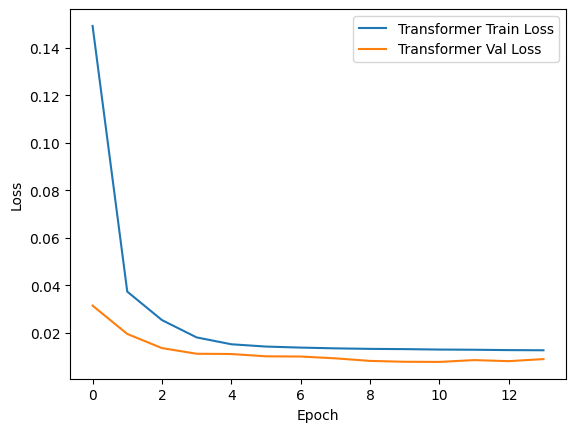

In [26]:
# plot the loss
import matplotlib.pyplot as plt

plt.plot(transformer_train_losses, label='Transformer Train Loss')  
plt.plot(transformer_val_losses, label='Transformer Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show();

In [27]:
# save the model
torch.save(model.state_dict(), 'models/transformer_model.pth')

In [28]:
def test_model(model, test_loader, loss_fn):
    model.eval()

    losses = []
    for lidar, non_lidar, actions in tqdm(test_loader):
        # Move the data to the device that is used
        lidar = lidar.to(device).unsqueeze(-1)
        non_lidar = non_lidar.to(device).unsqueeze(-1)
        actions = actions.to(device)

        # Forward pass
        actions_pred, _, _ = model(lidar.float(), non_lidar.float())        
        loss = loss_fn(actions_pred, actions.float())
        if loss.item() > 0.01:
            print(actions_pred - actions)
            print(loss)

        # Save the loss
        losses.append(loss.item())

    # return the average loss for this epoch
    return sum(losses)/len(losses)

In [29]:
model = Transformer(config_dict)
model.load_state_dict(torch.load('models/transformer_model.pth', map_location=torch.device('cpu')))
model.eval()
device = 'cpu'

# take world idx 0 as example
dataset = KULBarnDataset(df[df['world_idx'] == 0], "val")
print(len(dataset))
loader = DataLoader(dataset, batch_size=64, shuffle=False)

final_val_loss = test_model(model, loader, loss_fn)
print("Final val loss:", final_val_loss)

1789


  0%|          | 0/28 [00:00<?, ?it/s]

tensor([[ 6.7221e-01,  1.0194e-01],
        [ 6.4511e-01,  9.7106e-02],
        [ 6.1486e-01,  9.2488e-02],
        [ 5.8452e-01,  1.0445e-01],
        [ 5.5412e-01,  1.0261e-01],
        [ 5.2339e-01,  3.6847e-02],
        [ 4.9283e-01,  3.5109e-02],
        [ 4.6220e-01,  3.3313e-02],
        [ 4.3457e-01,  3.1314e-02],
        [ 4.0377e-01,  2.9532e-02],
        [ 3.7293e-01,  2.7730e-02],
        [ 3.4185e-01,  2.5696e-02],
        [ 3.1384e-01,  2.3023e-02],
        [ 2.8273e-01,  2.0897e-02],
        [ 2.5458e-01,  1.8663e-02],
        [ 2.2335e-01,  1.6294e-02],
        [ 1.9196e-01,  1.4176e-02],
        [ 1.6363e-01,  1.1926e-02],
        [ 1.3215e-01,  1.8920e-02],
        [ 1.0369e-01,  1.6965e-02],
        [ 7.2044e-02,  1.5086e-02],
        [ 4.3553e-02,  1.3852e-02],
        [ 1.1833e-02,  1.2782e-02],
        [-1.6883e-02,  1.1512e-02],
        [-3.5603e-02,  1.1212e-02],
        [-3.7498e-02, -3.5586e-04],
        [-3.6418e-02, -2.6153e-05],
        [-3.8480e-02, -1.736

 39%|███▉      | 11/28 [00:00<00:00, 103.16it/s]

tensor([[-0.1027,  0.0530],
        [-0.1069,  0.0990],
        [-0.1044,  0.1584],
        [-0.0724,  0.2642],
        [-0.0597, -0.0964],
        [-0.0584, -0.0080],
        [-0.0572, -0.2394],
        [-0.0530, -0.2378],
        [-0.0540, -0.2034],
        [-0.0478, -0.1956],
        [-0.0447, -0.1978],
        [-0.0459, -0.2825],
        [-0.0438, -0.1538],
        [-0.0433, -0.1261],
        [-0.0444, -0.1249],
        [-0.0434, -0.2561],
        [-0.0459, -0.2257],
        [-0.0388, -0.1332],
        [-0.0349, -0.1592],
        [-0.0291, -0.1667],
        [-0.0276, -0.2913],
        [-0.0247, -0.3084],
        [-0.0241, -0.1633],
        [-0.0237, -0.1865],
        [-0.0237, -0.1817],
        [-0.0204, -0.2099],
        [-0.0203, -0.1807],
        [-0.0243, -0.2180],
        [-0.0311, -0.2164],
        [-0.0394, -0.1694],
        [-0.0430, -0.1446],
        [-0.0464, -0.0703],
        [-0.0205, -0.0976],
        [-0.0269, -0.1410],
        [-0.0357, -0.2586],
        [-0.0430, -0

 82%|████████▏ | 23/28 [00:00<00:00, 102.91it/s]

tensor([[-0.0398,  0.0129],
        [-0.0396,  0.0025],
        [-0.0396,  0.0267],
        [-0.0421,  0.0398],
        [-0.0423,  0.0483],
        [-0.0420,  0.0397],
        [-0.0419,  0.0614],
        [-0.0429,  0.0964],
        [-0.0488,  0.1392],
        [-0.0515,  0.1444],
        [-0.0556,  0.1299],
        [-0.0629,  0.0827],
        [-0.0412,  0.2479],
        [-0.0437,  0.1799],
        [-0.0457,  0.1929],
        [-0.0524,  0.1642],
        [-0.0613,  0.1244],
        [-0.0743,  0.0917],
        [-0.0875,  0.0650],
        [-0.0974,  0.0633],
        [-0.1110,  0.0354],
        [-0.1188,  0.0129],
        [-0.1278, -0.0327],
        [-0.1232, -0.0241],
        [-0.0624,  0.1624],
        [-0.0768,  0.2890],
        [-0.0897,  0.2056],
        [-0.1080,  0.2331],
        [-0.1201,  0.1999],
        [-0.1299,  0.1660],
        [-0.1363,  0.0679],
        [-0.1363,  0.0944],
        [-0.1187,  0.0585],
        [-0.1044,  0.1132],
        [-0.1196,  0.0811],
        [-0.1343,  0

100%|██████████| 28/28 [00:00<00:00, 106.08it/s]

Final val loss: 0.006180316496673706


: 